# Notebook for running Poisson Switching LDS 
## No inputs, running on the time before stim
## Stim ONLY trials, no behavior
## Number of output dimensions = 3
## Number of phases = 2

In [1]:
path = "/home/clewis/repos/realSpike/data/rb50_20250127/switching_plds/k2_pre-stim/"

In [2]:
from scipy.linalg import block_diag
import autograd.numpy as np
import matplotlib.pyplot as plt
import ssm

from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import get_spike_events, kalman_filter, bin_spikes, butter_filter, plot_dynamics_2d, plot_dynamics_3d
from matplotlib import colormaps
import pandas as pd
import h5py

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D 

import random

%matplotlib inline

# Get data

In [3]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/MAT_FILES/rb50_20250127_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_laser_rec_time', 'any', 'cue', 'cue_rec_time', 'cue_trial_time', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'single', 'totTime', 'trial_start']>


# Get stim only trials

In [4]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]

# control_idxs = np.intersect1d(control_idxs, stim_idxs)
# con
stim_idxs = stim_idxs[stim_idxs > 150]
stim_idxs

array([151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       179, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220,
       221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289,
       290, 291, 292, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 330, 331, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [5]:
np.unique(data["pattern_id"][0, stim_idxs])

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29.])

In [6]:
stim_idxs.shape

(269,)

## Get relevant time information

In [7]:
laser_times = data["aligned_laser_rec_time"]
laser_times.shape

(450, 1)

## Get the AP.bin file

In [8]:
from real_spike.utils import get_sample_data, get_meta
import tifffile

In [9]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250127/rb50_20250127_g0/rb50_20250127_g0_t0.imec0.ap.meta")

In [10]:
meta_data = get_meta(meta_path)

In [11]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 166298223)

## Get conversion params

In [12]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

In [13]:
vmax

0.6

In [14]:
imax

512.0

In [15]:
gain

500.0

# Get trials

In [16]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(idxs):
        trial_no = i
        # get time points in ap space
        t = 50
        start_time = int((laser_times[trial_no, 0] - t) / 1_000 * 30_000)
        
        # get end of behavior = mouth (260ms) + 300ms 
        stim_t = 5
        t2 = 50
        end_time = int((laser_times[trial_no, 0] + stim_t + t2) / 1_000 * 30_000)
    
        trial = ap_data[:150, start_time:end_time]
    
        conv_data = 1e6 * trial / vmax / imax / gain
    
        filt_data = butter_filter(conv_data, 1_000, 30_000)
    
        c_start = int(laser_times[trial_no, 0] / 1_000 * 30_000)
        m_start = c_start - (30 * 2000)
        trial_median = ap_data[:150, m_start:c_start]
    
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        median = np.median(trial_median, axis=1)
    
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))
        
    return model_data

In [17]:
bin_size = 1

In [18]:
# model_data = get_trials(stim_idxs, bin_size)

In [26]:
# save as a pickle file 
import pickle

In [27]:
filename = f"/home/clewis/repos/realSpike/data/rb50_20250127/plds_stim/{bin_size}ms_data.pkl"
# with open(filename, "wb") as file:
#     pickle.dump(model_data, file)

In [28]:
with open(filename, "rb") as file:
    model_data = pickle.load(file)

# Fit model on time before stim 

In [29]:
model_data = [m[:50, :] for m in model_data]

In [30]:
model_data[0].shape

(50, 150)

# Fit the model

In [46]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.SLDS(N=obs_dim, K=2, D=state_dim, emissions="poisson", emission_kwargs=dict(link="softplus"))

elbos, q = plds.fit(model_data, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Visualize the results

In [41]:
# plot my elbos

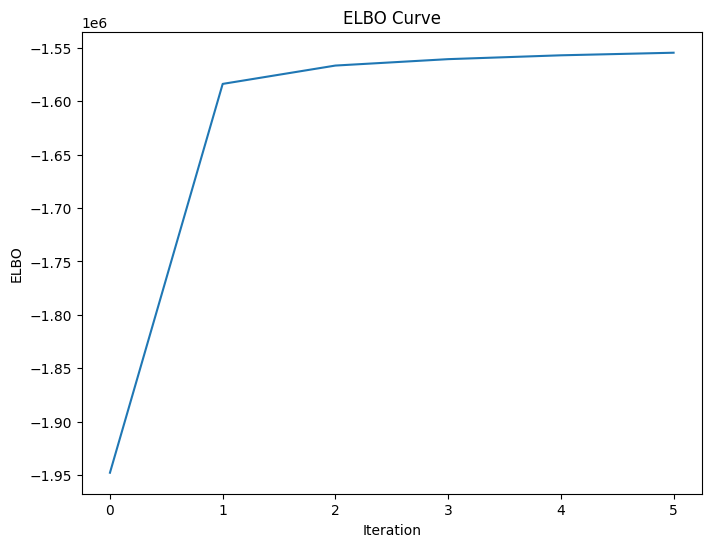

In [47]:
plt.figure(figsize=(8, 6))

plt.plot(elbos)

plt.xlabel("Iteration")
plt.ylabel("ELBO")

plt.title("ELBO Curve")

plt.show()

## Dynamics

In [48]:
As = plds.dynamics.As
As.shape

(2, 3, 3)

In [49]:
b = plds.dynamics.b
b.shape

(3,)

In [50]:
from matplotlib.patches import Patch

In [51]:
state_means = q.mean_continuous_states

# Eigenvalue Decomposition on `A`

[0.08360178 0.13067436 0.18254052]
[0.22378241 0.2894483  0.26971649]


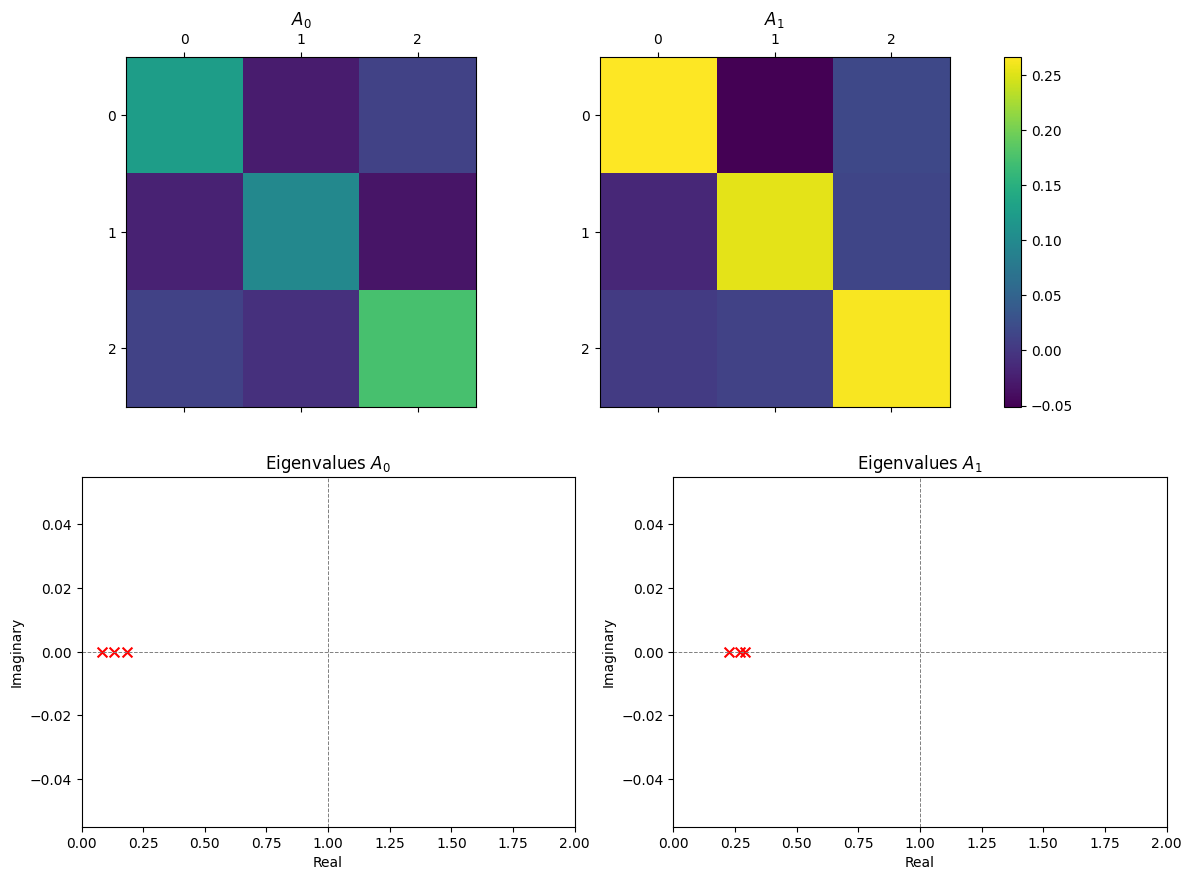

In [133]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

vmin = min(mat.min() for mat in [As[0], As[1]])
vmax = max(mat.max() for mat in [As[0], As[1]])

for i in range(2):
    ax = axes[i]
    im = ax.matshow(As[i], vmin=vmin, vmax=vmax)
    ax.set_title(f"$A_{i}$")

    eigvals, eigvecs = np.linalg.eig(As[i])
    axes[i+2].axhline(0, color='gray', linestyle='--', linewidth=0.7)
    axes[i+2].axvline(1, color='gray', linestyle='--', linewidth=0.7)

    print(eigvals.real)
    #ax.colorbar()

    axes[i+2].scatter(eigvals.real, eigvals.imag, c='red', s=50, marker="x")

    axes[i+2].set_xlim((0, 2))
    
    axes[i+2].set_title(f"Eigenvalues $A_{i}$")
    
    axes[i+2].set_xlabel("Real")
    axes[i+2].set_ylabel("Imaginary")


fig.colorbar(im, ax=axes[:2]) 

plt.savefig(f"{path}A.png")

plt.show()

# Plot the dynamics

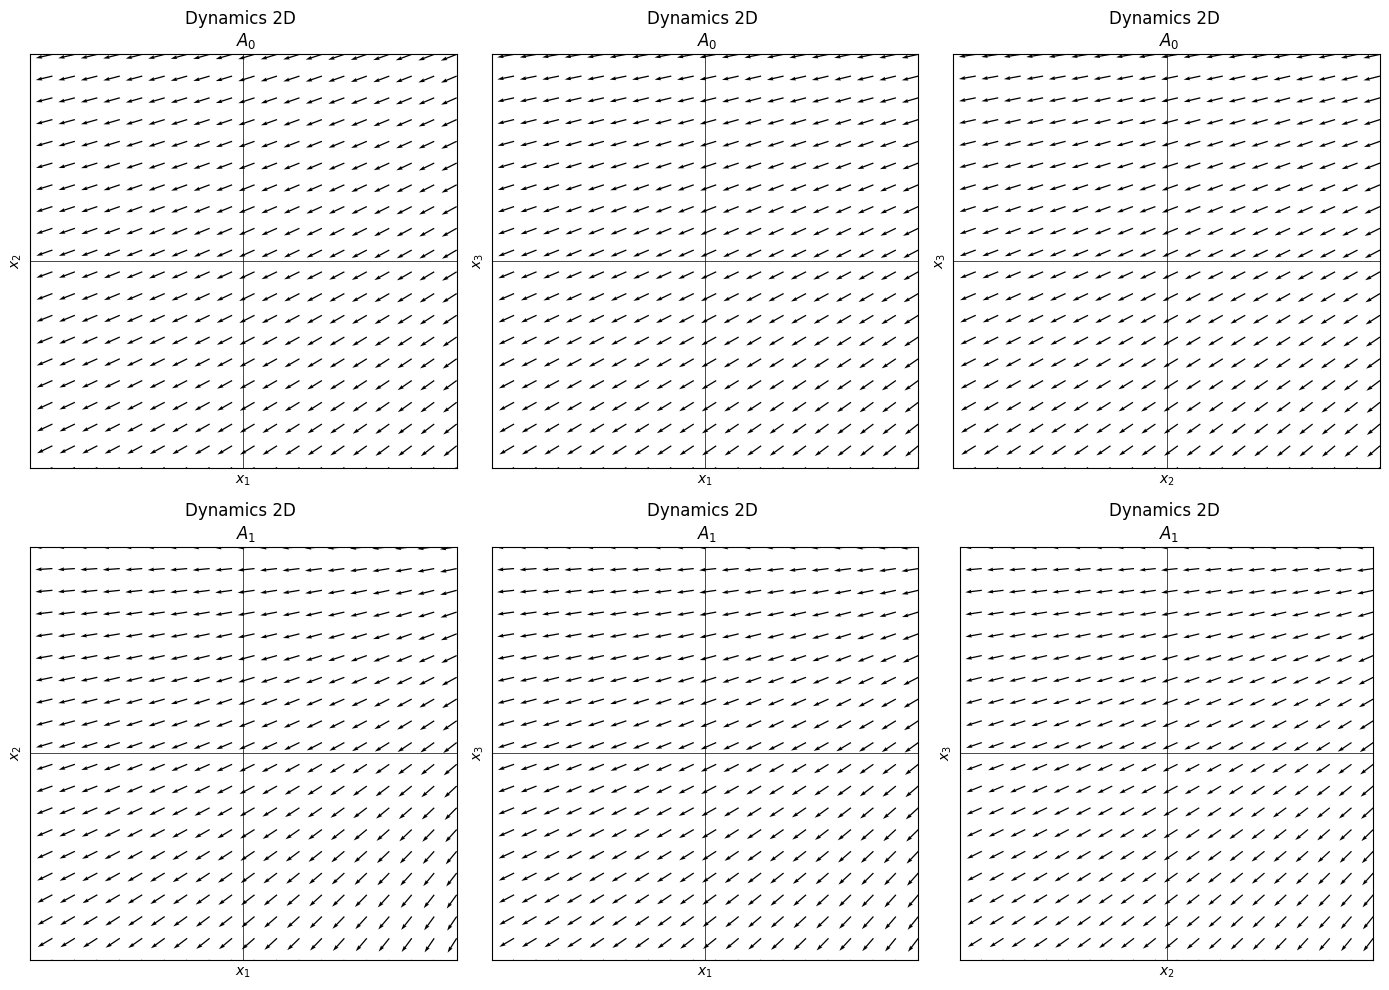

In [136]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

axes = axes.flatten()


A = As[0]

ax = axes[0]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  + b[0]
V = A[1,0]*X + A[1,1]*Y + b[1]

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")


A = As[0][[0, 2], :][:, [0, 2]]
ax = axes[1]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  + b[0]
V = A[1,0]*X + A[1,1]*Y + b[1]

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_3$")


A = As[0][[1, 2], :][:, [1, 2]]
ax = axes[2]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  + b[0]
V = A[1,0]*X + A[1,1]*Y + b[1]

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_2$")
ax.set_ylabel("$x_3$")

A = As[1]

ax = axes[0+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  + b[0]
V = A[1,0]*X + A[1,1]*Y + b[1]

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")


A = As[1][[0, 2], :][:, [0, 2]]
ax = axes[1+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  + b[0]
V = A[1,0]*X + A[1,1]*Y + b[1]

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_3$")


A = As[1][[1, 2], :][:, [1, 2]]
ax = axes[2+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  + b[0]
V = A[1,0]*X + A[1,1]*Y + b[1]

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_2$")
ax.set_ylabel("$x_3$")

plt.gca().set_aspect('equal')

plt.tight_layout()

plt.savefig(f"{path}dynamics.png")
plt.show()

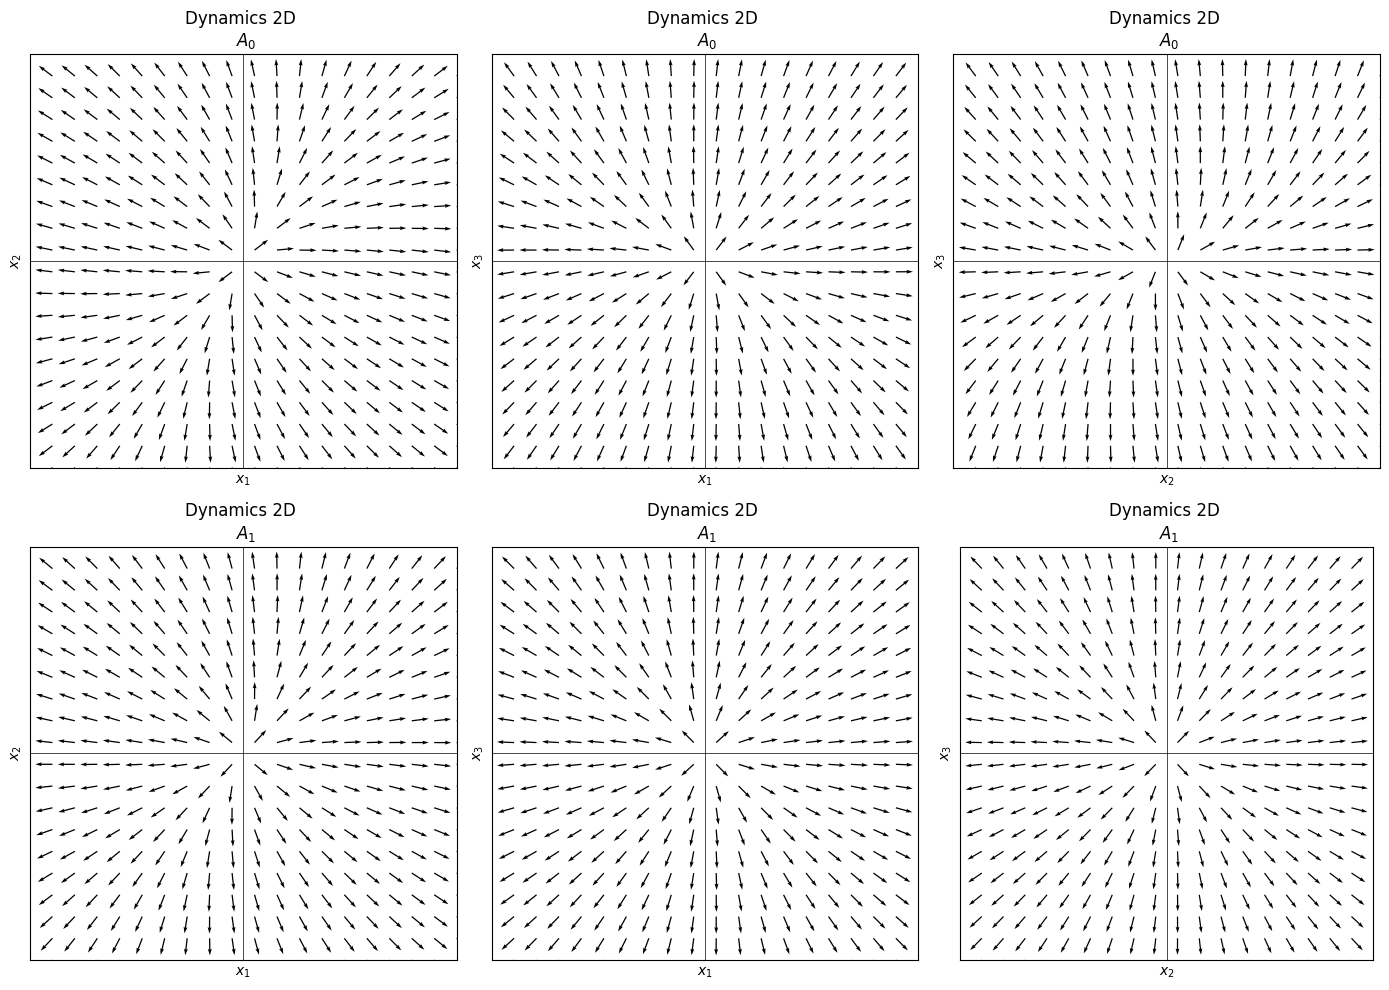

In [137]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

axes = axes.flatten()


A = As[0]

ax = axes[0]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")


A = As[0][[0, 2], :][:, [0, 2]]
ax = axes[1]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 
# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_3$")


A = As[0][[1, 2], :][:, [1, 2]]
ax = axes[2]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y 
V = A[1,0]*X + A[1,1]*Y

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{0}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_2$")
ax.set_ylabel("$x_3$")

A = As[1]

ax = axes[0+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")


A = As[1][[0, 2], :][:, [0, 2]]
ax = axes[1+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_3$")


A = As[1][[1, 2], :][:, [1, 2]]
ax = axes[2+3]

x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)

# Compute vector field: z_dot = A z
U = A[0,0]*X + A[0,1]*Y  
V = A[1,0]*X + A[1,1]*Y 

# Normalize for nicer arrows
N = np.sqrt(U**2 + V**2)
U, V = U/N, V/N

# Plot
ax.quiver(X, Y, U, V, angles="xy", scale=25)
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
    
ax.set_title(f'Dynamics 2D \n $A_{1}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("$x_2$")
ax.set_ylabel("$x_3$")

plt.gca().set_aspect('equal')

plt.tight_layout()

plt.savefig(f"{path}dynamics2.png")
plt.show()

In [50]:
state_means[0].shape

(105, 3)

In [58]:
colors = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(model_data))]

# Plot the state means 

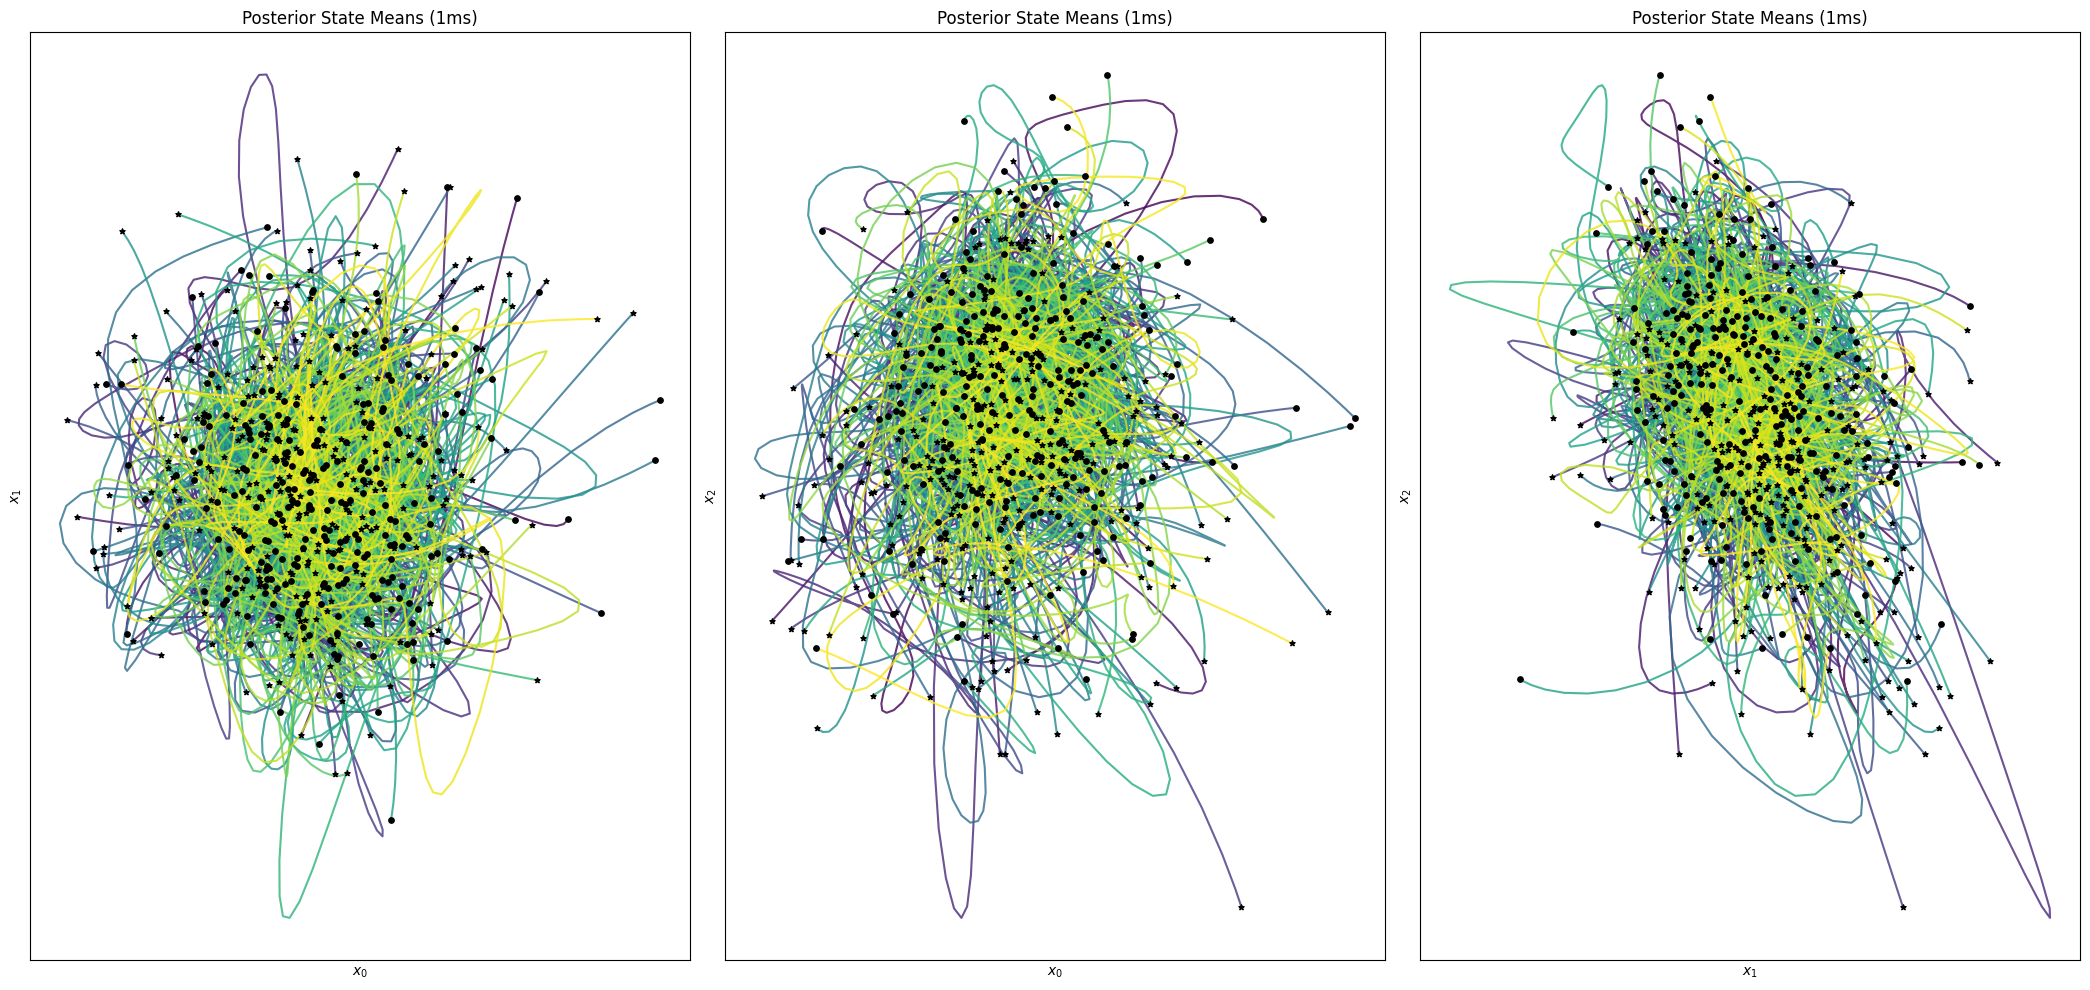

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(21, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(state_means):

    p = gaussian_filter1d(p, 4, axis=0)

    axes[0].plot(p[:, 0], p[:, 1], c=colors[i], zorder=0, alpha=0.8)

  #  axes[0].scatter(p[0, 0], p[0, 1], s=35, c="black", zorder=1, alpha=1)
    axes[0].scatter(p[0, 0], p[0, 1], s=15, marker='o', c="black", zorder=1, alpha=1)
    axes[0].scatter(p[-1, 0], p[-1, 1], s=15, marker='*', c="black", zorder=1, alpha=1)

    axes[1].plot(p[:, 0], p[:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[1].scatter(p[0, 0], p[0, 2], s=15, c="black", zorder=1, alpha=1)

    axes[1].scatter(p[-1, 0], p[-1, 2], s=15, marker='*', c="black", zorder=1, alpha=1)

    axes[2].plot(p[:, 1], p[:, 2], c=colors[i], zorder=0, alpha=0.8)

    axes[2].scatter(p[0, 1], p[0, 2], s=15, c="black", zorder=1, alpha=1)
    axes[2].scatter(p[-1, 1], p[-1, 2], s=15, marker='*', c="black", zorder=1, alpha=1)




for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Posterior State Means ({bin_size}ms)")
    #ax.legend(handles=custom_patches)


# 0, 0 = x1 vs x2
axes[0].set_xlabel(f"$x_0$")
axes[0].set_ylabel(f"$x_1$")


# 0, 1 = x1 vs x3
axes[1].set_xlabel(f"$x_0$")
axes[1].set_ylabel(f"$x_2$")

# 0, 2 = x2 vs x3
axes[2].set_xlabel(f"$x_1$")
axes[2].set_ylabel(f"$x_2$")

plt.savefig(f"{path}state_means.png")

plt.tight_layout()

# Plot most likely states

In [60]:
discrete_states = list()

for i in range(len(state_means)):
    z_s = plds.most_likely_states(state_means[i], model_data[i])
    discrete_states.append(z_s)

In [61]:
# plot each row 
s = np.array(discrete_states)
s.shape

(269, 50)

In [62]:
import matplotlib.colors as mcolors

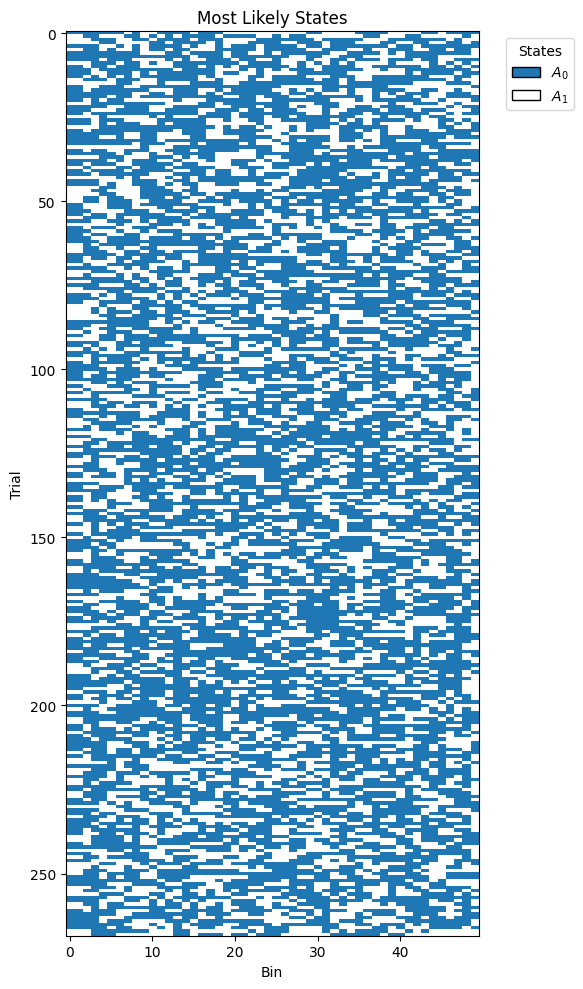

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))

color1 = 'tab:blue'
color2 = 'white'

# Create the colormap from the list of colors
cmap = mcolors.LinearSegmentedColormap.from_list(
    "ThreeColors", [color1, color2]
)


cax = ax.matshow(s, cmap=cmap, aspect="auto")

plt.tight_layout()

ax.set_xlabel("Bin")
ax.set_ylabel("Trial")

ax.xaxis.set_ticks_position('bottom')

ax.set_title("Most Likely States")

cs = {0: color1, 1: color2}
labels = {0: '$A_0$', 1: '$A_1$'}

patches = [Patch(facecolor=cs[val], label=labels[val], edgecolor="black")
               for val in sorted(cs.keys())]

plt.legend(handles=patches, title="States", bbox_to_anchor=(1.05, 1), loc='upper left')

#fig.colorbar(cax)

plt.tight_layout()

plt.savefig(f"{path}states.png")

plt.show()

# State means over time

In [80]:
import fastplotlib as fpl 
from ipywidgets import IntSlider, VBox, Layout

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


In [89]:
fig = fpl.Figure(cameras="3d")

d = [gaussian_filter1d(p, 4, axis=0) for p in state_means]

lc = fig[0,0].add_line_collection(d, thickness=2, colors=colors)    

RFBOutputContext()

/home/clewis/venvs/bah/lib64/python3.11/site-packages/pygfx/objects/_ruler.py:270: RuntimeWarning: divide by zero encountered in divide
  screen_full = (ndc_full[:, :2] / ndc_full[:, 3:4]) * half_canvas_size
/home/clewis/venvs/bah/lib64/python3.11/site-packages/pygfx/objects/_ruler.py:270: RuntimeWarning: invalid value encountered in divide
  screen_full = (ndc_full[:, :2] / ndc_full[:, 3:4]) * half_canvas_size
/home/clewis/venvs/bah/lib64/python3.11/site-packages/pygfx/objects/_ruler.py:282: RuntimeWarning: invalid value encountered in divide
  screen_sel = (ndc_sel[:, :2] / ndc_sel[:, 3:4]) * half_canvas_size
/home/clewis/venvs/bah/lib64/python3.11/site-packages/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


In [90]:
slider = IntSlider(min=1, max=model_data[0].shape[0]-1, value=model_data[0].shape[0]-1, layout=Layout(width="50%"))

In [91]:
def update(ev):
    t = ev["new"]

    for g in lc:
        g.colors[:, -1] = 1
        g.colors[t:, -1] = 0

In [92]:
slider.observe(update, "value")

In [93]:
VBox([fig.show(), slider])

In [94]:
fig.close()